# Graph Relationships Among University of Utah Faculty
### &copy; Brian E. Chapman, Ph.D.

In this notebook, we will create graphs that shows co-authorship relationships between faculty from either Biomedical Informatics or Human Genetics at the University of Utah. Co-authorship is determined by querying the Pubmed database using the [Biopython](https://github.com/biopython/biopython.github.io/) [Entrez](http://biopython.org/DIST/docs/api/Bio.Entrez-module.html) subpackage. Graphs are created using [NetworkX](https://networkx.github.io/)


### Key Concepts
#### These concepts and applications might be new to the student.

* Graphs
* Gzip
* Pickle
* [set](https://docs.python.org/3.5/tutorial/datastructures.html#sets)
* Graphviz

In [1]:
%matplotlib inline

## Querying the Entrez Database

In this notebook we will be querying papers in the PubMed database. For an example of querying the nucleotide database for a sequence click [here](./BasicEntrezQuery.ipynb)

### The notebook Allows the User to Either create New Pubmed data or use cached results

#### Set ``GET_NEW_DATA`` to True to query Entrez

In [2]:
GET_NEW_DATA = True

In [3]:
from Bio import Entrez
import networkx as nx
import os
DATADIR = os.path.join(os.path.expanduser("~"),"DATA", "Graphs")
if not GET_NEW_DATA:
    DATADIR = os.path.join(os.path.expanduser("~"), "work", "graphs")
    if not os.path.exists(DATADIR):
        os.makedirs(DATADIR)
    
print(os.path.exists(DATADIR))
from IPython.display import Image
import gzip
import pickle
import numpy as np


True


### Faculty Names

* Human Genetic faculty names were scrapped from the department website
* Biomedical Informatics faculty names were taken from training grant materials


In [4]:
hg_faculty = ['Mario Capecchi',
 'Richard Cawthon',
 'Clement Chow',
 'Nels Elde',
 'Cedric Feschotte',
 'David J. Grunwald',
 'Sandra J. Hasstedt',
 'Michael T. Howard',
 'Lynn B. Jorde',
 'Gabrielle Kardon',
 'Kristen M. Kwan',
 'Mark F. Leppert',
 'Anthea Letsou',
 'Suzanne L. Mansour',
 'Gabor Marth',
 'Mark M. Metzstein',
 'Charles Murtaugh',
 'Ellen J. Pritham',
 'Aaron Quinlan',
 'Shigeru Sakonju',
 'Gillian Stanfield',
 'Louisa Stark',
 'Carl S. Thummel',
 'Robert B. Weiss',
 'Mark Yandell']
bmi_faculty = ['Samir E AbdelRahman',
 'Bruce E Bray',
 'Wendy W Chapman',
 'Michael A Conway',
 'Guilherme Del Fiol',
 'Karen Eilbeck',
 'R. Scott Evans',
 'Julio C Facelli',
 'Jennifer H Garvin',
 'Bryan S Gibson',
 'Ramkiran Gouripeddi',
 'Peter J Haug',
 'Rachel Hess',
 'Stanley M Huff',
 'John F Hurdle',
 'Kensaku Kawamoto',
 'Younghee Lee',
 'Gang Luo',
 'Stephane M Meystre',
 'Scott P Narus',
 'Jonathan Nebeker',
 'Stephen Piccolo',
 'Aaron Quinlan',
 'Catherine J Staes',
 'Katherine A Sward',
 'Charlene R Weir']

## Functions for Querying Entrez

In [5]:
def join_first_last(name):
    return " ".join(split_name(name))
def split_name(name):
    tmp = name.split()
    return tmp[0],tmp[-1]
def check_author_faculty(author, faculty):
    a = split_name(author)
    
    for f in faculty:
        if a[0] in f and a[1] in f:
            return True
    return False

### Get the pubmed IDs matching query

In [6]:
def search(query, email = None):
    if email == None:
        raise ValueError("Must provde a valid e-mail")
    Entrez.email = email
    handle = Entrez.esearch(db='pubmed', 
                            sort='relevance', 
                            retmax='100',
                            retmode='xml', 
                            term=query)
    results = Entrez.read(handle)
    return results

### Fetch papers corresponding to ids

In [7]:
def fetch_details(id_list, email=None, retmode='json'):
    if email == None:
        raise ValueError("Must provde a valid e-mail")
    ids = ','.join(id_list)
    Entrez.email = email
    handle = Entrez.epost(db='pubmed',
                           id=ids)
    results = Entrez.read(handle)
    webenv = results["WebEnv"]
    query_key = results["QueryKey"]
    fetch_handle = Entrez.efetch(db='pubmed', 
                                 rettype='xml',
                                 retmode=retmode,
                                 webenv=webenv, 
                                 query_key=query_key)
    return [r for r in Entrez.read(fetch_handle, validate=False)["PubmedArticle"]]
    return fetch_handle.read()


### Get Co-authorship

Entrez returns a lot of information. We hone it down to just the names. We need to use exceptions because the returned papers doesn't always have the fields we want.

In [ ]:
# help(Entrez.efetch)

In [8]:
def get_coauthor_lists(papers):
    paper_authors = {}
    for p in papers:
        try:
            tmp = p['MedlineCitation']
            alist = []
            for a in tmp['Article']['AuthorList']:
                try:
                    s = "%s %s"%(a['ForeName'],a['LastName'])
                    alist.append(s)
                except Exception as error:
                    pass
            paper_authors[tmp['Article']['ArticleTitle']] = alist
        except:
            pass
    return paper_authors

In [9]:

def get_faculty_coauthors(faculty):
    return get_coauthor_lists( 
        fetch_details(search(faculty)['IdList']))

In [10]:
def get_faculty_coauthorship(faculty, email=None):
    if email == None:
        raise ValueError("Must provide valid e-mail")
    faculty_ids = {f:search(f, email=email)['IdList'] for f in faculty}
    faculty_details_text = {f:fetch_details(ids, retmode='xml', email=email) for f, ids in faculty_ids.items() if ids}
    coauthors = {f:get_coauthor_lists(ad) for f, ad in faculty_details_text.items()}
    return coauthors

In [11]:
if GET_NEW_DATA:
    hg_coauthorship = get_faculty_coauthorship(hg_faculty, email="brian.chapman@utah.edu")
    bmi_coauthorship = get_faculty_coauthorship(bmi_faculty, email="brian.chapman@utah.edu")

In [12]:
if GET_NEW_DATA:
    with gzip.open(os.path.join(DATADIR, "hg_coauthorship.pickle.gz"), "wb") as f0:
        pickle.dump(hg_coauthorship, f0)

    with gzip.open(os.path.join(DATADIR, "bmi_coauthorship.pickle.gz"), "wb") as f0:
        pickle.dump(bmi_coauthorship, f0)

OSError: [Errno 30] Read-only file system: '/home/jovyan/DATA/Graphs/hg_coauthorship.pickle.gz'

In [13]:
hg_coauthorship

{'Aaron Quinlan': {'A map of human genome variation from population-scale sequencing.': ['Gonçalo R Abecasis',
   'David Altshuler',
   'Adam Auton',
   'Lisa D Brooks',
   'Richard M Durbin',
   'Richard A Gibbs',
   'Matt E Hurles',
   'Gil A McVean'],
  'A novel IFITM5 mutation in severe atypical osteogenesis imperfecta type VI impairs osteoblast production of pigment epithelium-derived factor.': ['Charles R Farber',
   'Adi Reich',
   'Aileen M Barnes',
   'Patricia Becerra',
   'Frank Rauch',
   'Wayne A Cabral',
   'Alison Bae',
   'Aaron Quinlan',
   'Francis H Glorieux',
   'Thomas L Clemens',
   'Joan C Marini'],
  'A reference bacterial genome dataset generated on the MinION™ portable single-molecule nanopore sequencer.': ['Joshua Quick',
   'Aaron R Quinlan',
   'Nicholas J Loman'],
  'Analysis of 6,515 exomes reveals the recent origin of most human protein-coding variants.': ['Wenqing Fu',
   "Timothy D O'Connor",
   'Goo Jun',
   'Hyun Min Kang',
   'Goncalo Abecasis',
   

### Local Data

The connection with the Entrez database can be problematic. If you are having difficulty try loading the data I have previously generated. The files are stored in compressed ([gzip](https://en.wikipedia.org/wiki/Gzip)) [pickle](https://docs.python.org/3/library/pickle.html) files. Gzip is a common compression algorithm while pickle is a Python-specific format for writing Python objects to disk. gzipped files can be opened directly by Python and then treated like a normal file. See the documentation for the Python [gzip library](https://docs.python.org/3/library/gzip.html). When I generated the files I used the  [``pickle.dump``](https://docs.python.org/3/library/pickle.html#pickle.dump) function to store ``hg_coauthorship`` and ``bmi_coauthorship`` in individual files.

Read the documentation to figure out how to **load** the data back into a Python program.

In [14]:
if not GET_NEW_DATA:
    with gzip.open(os.path.join(DATADIR, "hg_coauthorship.pickle.gz"), "rb") as f0:
        hg_coauthorship = pickle.load(f0)
    with gzip.open(os.path.join(DATADIR, "bmi_coauthorship.pickle.gz"), "rb") as f0:
        bmi_coauthorship = pickle.load(f0)

## Created Undirected Graphs of Co-authorships
### We will limit nodes of the graphs to faculty of the department

* If we do not add a co-author to the graph we will add them to a list
* We will start by creating graphs where we check the author names return from PubMed against the list of faculty names we defined at the top of the notebook.
    * We can create either a NetworkX [MultiGraph](https://networkx.github.io/documentation/development/reference/classes.multigraph.html?highlight=multigraph) or a [Graph](https://networkx.github.io/documentation/development/reference/classes.graph.html). A MultiGraph allows for multiple edges (relationships) between nodes (authors), while a Graph allows for only a single edge between two nodes.
    * What might be the potential uses of both styles of graphs in an analysis of co-authorships?



In [15]:
def create_authorship_graph_naive(coauthors, faculty, graph_type = "multi"):
    """
    
    """
    if graph_type == "multi":
        authorship = nx.MultiGraph()
    else:
        authorship = nx.Graph()
        
    not_added = []
    faculty_tuples = [split_name(x) for x in faculty]
    for author, papers in coauthors.items():
        for title, authors in papers.items():
            for a in authors:
                if a != author:
                    if a in faculty:
                        authorship.add_edge(author, 
                                            a, key=title, attr_dict={"paper":title})
                    else:
                        not_added.append(a)
    return authorship, not_added

### Notes

* ``_``: an underscore is commonly used for a throwaway variable

In [16]:
mgraphn_hg, not_added_n_hg = create_authorship_graph_naive(hg_coauthorship, hg_faculty)
graphn_hg, _ = create_authorship_graph_naive(hg_coauthorship, hg_faculty, graph_type = "graph")

mgraphn_bmi, not_added_n_bmi = create_authorship_graph_naive(bmi_coauthorship, bmi_faculty)
graphn_bmi, _ = create_authorship_graph_naive(bmi_coauthorship, bmi_faculty, graph_type = "graph")

### Explore the graphs

NetworkX has functions for basic descriptions of graphs, such as the number of nodes and number of edges. There are also functions for characterizing the nodes of a graphs, such as the degree (the number of edges connected to a node. We can draw the graphs with matplotlib 

#### Explore the following drawing functions
* ``nx.draw``
* ``nx.draw_spring``
* ``nx.draw_spectral``
* ``nx.draw_circular``

11
11 9


/opt/conda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/opt/conda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/opt/conda/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/opt/conda/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


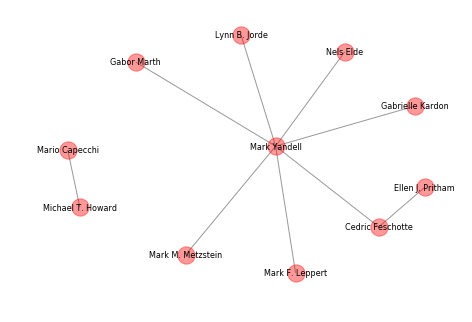

In [17]:
print(len(graphn_hg))
print(graphn_hg.number_of_nodes(), graphn_hg.number_of_edges())
nx.draw(graphn_hg, with_labels=True, alpha=0.4, font_size=8)

21
21 55


/opt/conda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/opt/conda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/opt/conda/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/opt/conda/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


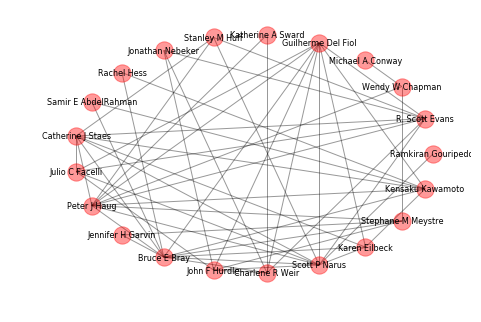

In [18]:
print(len(graphn_bmi))
print(graphn_bmi.number_of_nodes(), graphn_bmi.number_of_edges())
nx.draw_circular(graphn_bmi, with_labels=True, alpha=0.4, font_size=8)

## Draw the Graphs with Graphviz

While NetworkX comes with a built in Matplotlib drawing interface, it takes a lot of customization to make owrthwhile figures. Instead we will use NetworkX's interface to [graphviz](http://www.graphviz.org/) to generate figures. We will have to save the figures to disk and then use the IPython notebook [``display.Image``](http://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html?highlight=display.image#functions) function to draw the figures in the notebook.

In [19]:
def save_graph(g, name):
    """
    """
    ag = nx.nx_pydot.to_pydot(g)
    fname = name+".png"
    ag.write_png(fname)
    return fname

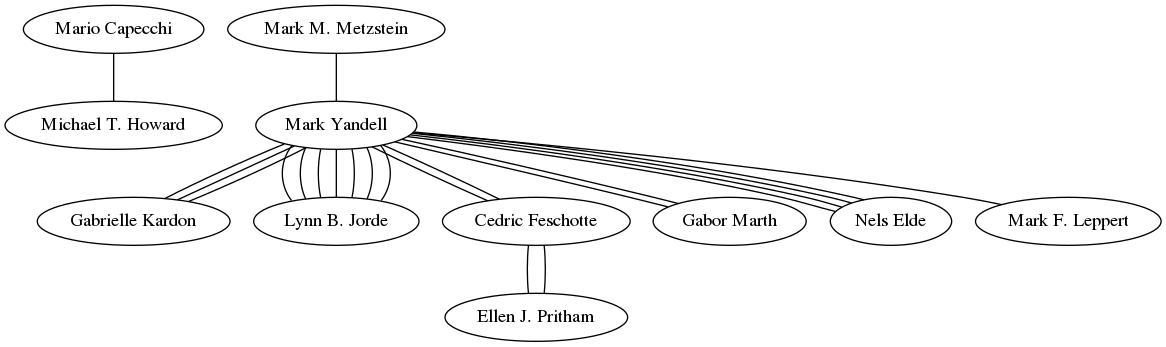

In [20]:
Image(save_graph(mgraphn_hg,"mgraphn_hg"))

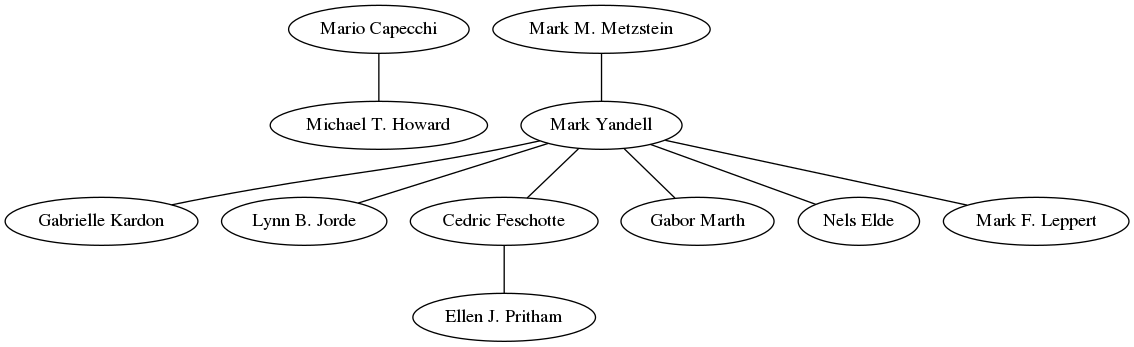

In [21]:
Image(save_graph(graphn_hg,"graphn_hg"))

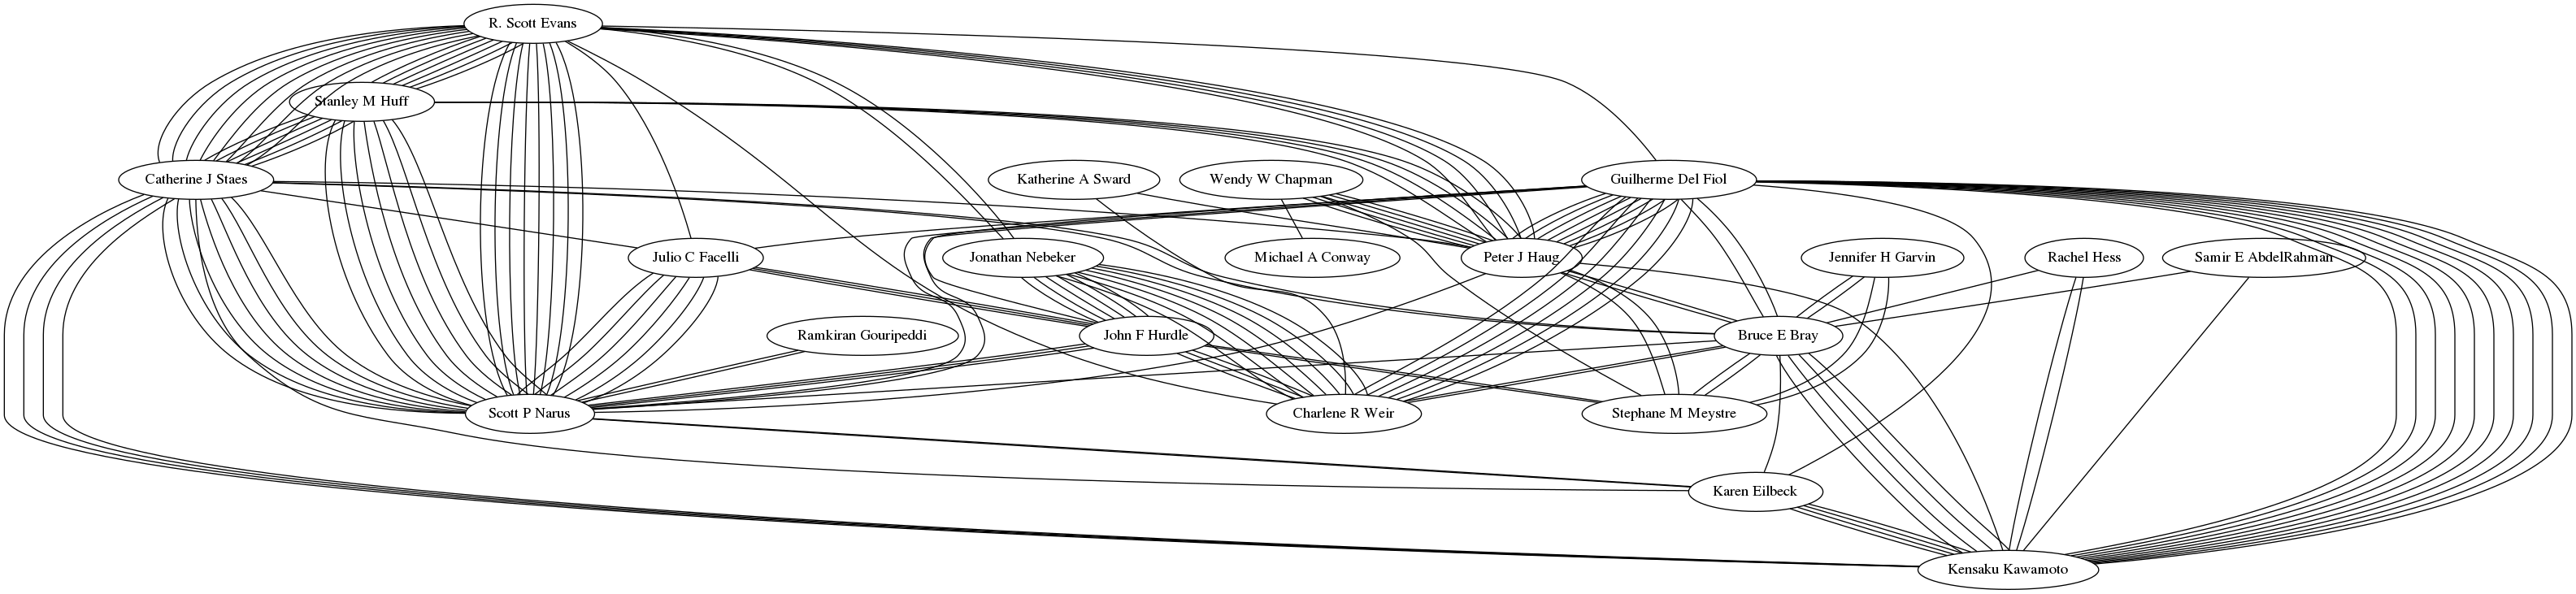

In [22]:
Image(save_graph(mgraphn_bmi,"mgraphn_bmi"))

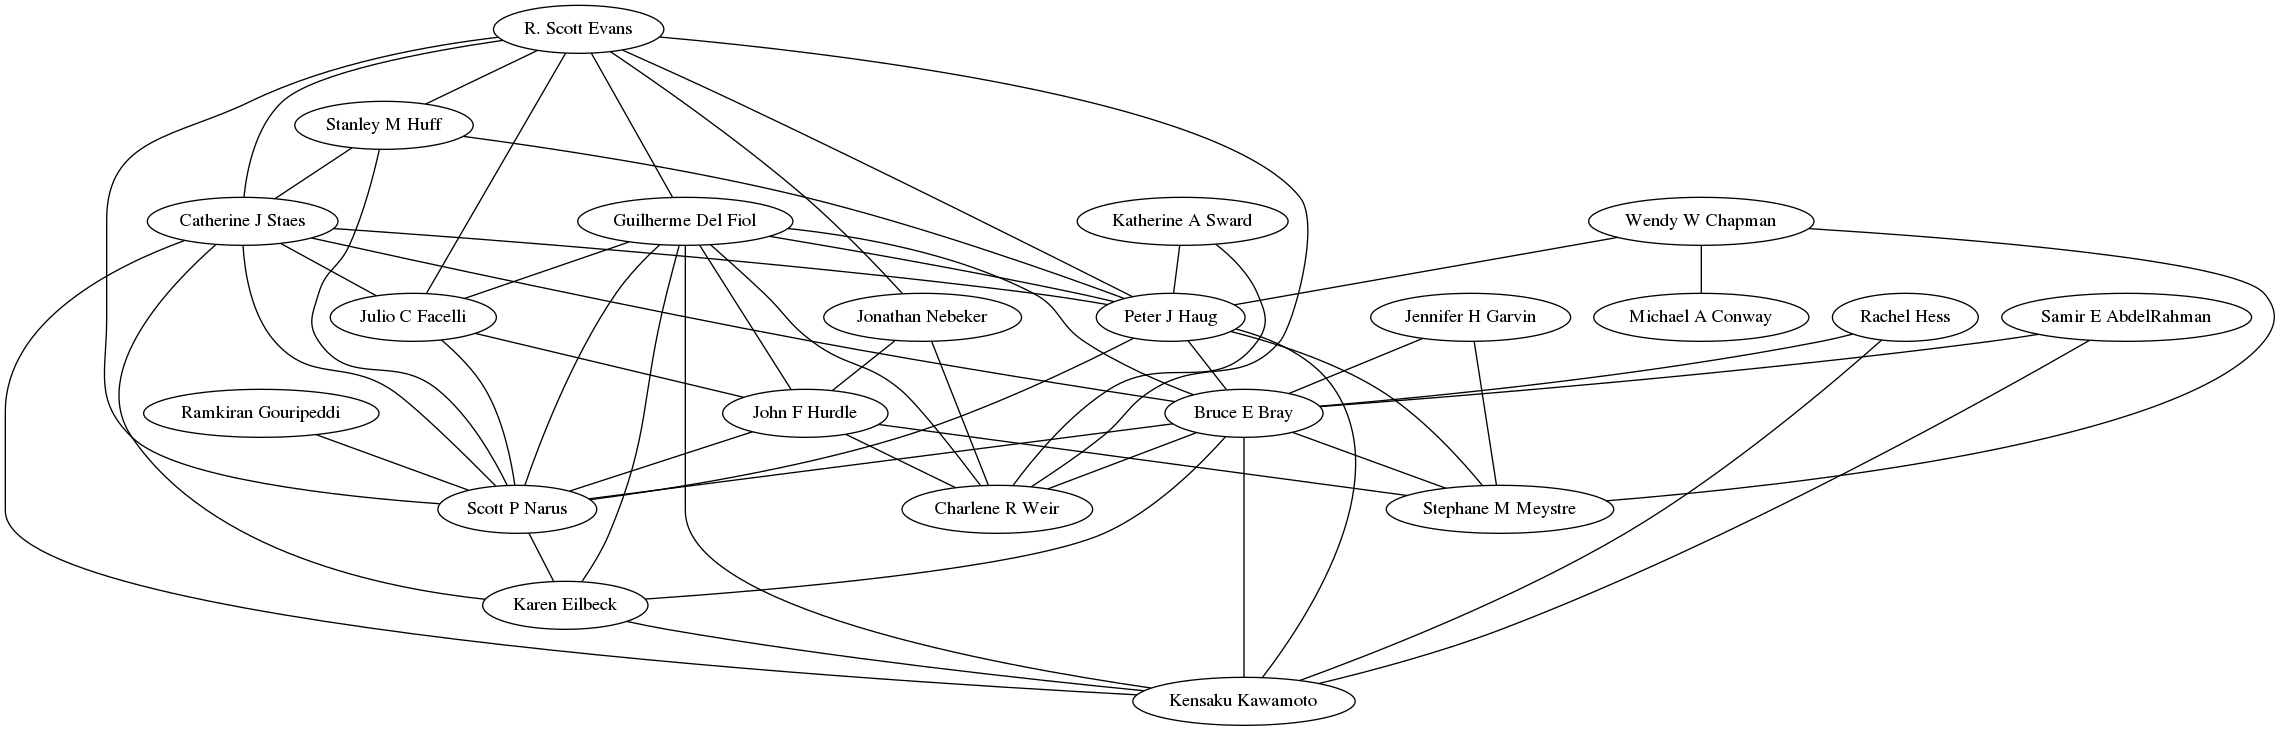

In [23]:
Image(save_graph(graphn_bmi,"graphn_bmi"))

## Examine Our Data

The Human Genetics graph seems suspiciously small. We should look at whom we didn't add.


In [ ]:
print("Number of authors not added to the graph:", len(not_added_n_hg))

Authors may not have been added to the graph multiple times (a non-faculty author on multiple paper). We can use a Python [set](https://docs.python.org/3.5/tutorial/datastructures.html#sets) to get the unique set of authors not added. For more information about sets click [here](./sets_and_python.ipynb)

In [ ]:
len(set(not_added_n_hg))

The set of unique authors not added is about half the size of the not added list. This list would consist of students, collaborators from other departments and universities, etc. But is there any chance we didn't add someone we should have?

## Exercise

How would you check whether Mark Yandell was ever incorrectly **not** added?

## Creating a Better Graph Generation Function

One of the challenges we have with our graph generation is that we do not consistently use names. Sometimes I'm "Brian Chapman" other times I'm "Brian E. Chapman". The same could be true of other authors. If the web page from which I got the faculty names uses names different than how the faculty names appear in PubMed, we would have problems. 

The most likely problem is with middle names so we could write a function that extracts the first and last name from a name string and we could write another function that checks first names and last names against the list of faculty names (using only the first and last names from that list).

Using our first/last name checking algorithm we can create a better graph generation function

In [ ]:
def create_authorship_graph(coauthors, faculty, graph_type = "multi"):
    """
    
    """
    if graph_type == "multi":
        authorship = nx.MultiGraph()
    else:
        authorship = nx.Graph()
        
    not_added = []
    faculty_tuples = [split_name(x) for x in faculty]
    for author, papers in coauthors.items():
        for title, authors in papers.items():
            for a in authors:
                if join_first_last(a) != join_first_last(author):
                    if check_author_faculty(a, faculty_tuples):
                        authorship.add_edge(join_first_last(author), 
                                            join_first_last(a), key=title, attr_dict={"paper":title})
                    else:
                        not_added.append(a)
    return authorship, not_added

In [ ]:
mgraph_hg, not_added_hg = create_authorship_graph(hg_coauthorship, hg_faculty)
graph_hg, _ = create_authorship_graph(hg_coauthorship, hg_faculty, graph_type = "graph")

mgraph_bmi, not_added_bmi = create_authorship_graph(bmi_coauthorship, bmi_faculty)
graph_bmi, _ = create_authorship_graph(bmi_coauthorship, bmi_faculty, graph_type = "graph")

## Examine Our Data

In [ ]:
print("Number of authors not added to the graph:", len(set(not_added_hg)))
print(print(mgraph_hg.number_of_nodes(), mgraph_hg.number_of_edges())
)

In [ ]:
print("Number of authors not added to the graph:", len(set(not_added_bmi)))
print(print(mgraph_bmi.number_of_nodes(), mgraph_bmi.number_of_edges()))

In [ ]:
Image(save_graph(mgraph_hg,"mgraph_hg"))

In [ ]:
Image(save_graph(graph_hg,"graph_hg"))

In [ ]:
Image(save_graph(mgraph_bmi,"mgraph_bmi"))

In [ ]:
Image(save_graph(graph_bmi,"graph_bmi"))

## Exercise 

* Jonathan Nebeker was incorrectly added as a primary faculty in Biomedical Informatics. How can you delete Dr. Nebeker from the graph along with all edges connecting to him?

## Exercise: How Do the Graphs Compare?

* What are the average clustering of the graphs?
* What are the diameter of the graphs?
* What are the average shortest paths of the graphs?

**Hint:** Functions for each of these questions are provided by NetworkX can be found in the [documentation](http://networkx.readthedocs.io/en/stable/index.html)

In [ ]:
def get_graph_degrees(g):
    gd = [(n,g.degree(n)) for n in g.nodes()]
    gd.sort(key = lambda x: x[1], reverse = True)
    return gd

In [ ]:
def print_graph_node_degree_value(g):
    for x in get_graph_degrees(g):
        print("%s%s"%(("%s"%x[0]).ljust(30),("% 2d"%x[1]).rjust(5)))

In [ ]:
print_graph_node_degree_value(mgraph_bmi)

In [ ]:
print_graph_node_degree_value(mgraph_hg)

In [ ]:
print_graph_node_degree_value(graph_hg)

In [ ]:
print_graph_node_degree_value(graph_bmi)

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">University of Uah Data Science for Health</span> by <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Brian E. Chapman</span> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.